In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy
from sklearn.feature_selection import mutual_info_regression

from tqdm import tqdm

from models import QRes, NN

sns.set_style("white")

plt.rcParams.update({                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "figure.figsize": (12,8),
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "font.size": 11,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    })

# Train with Sparse Data

Objective function: $$y = \sin(6x)$$

In [2]:
model = NN(
    input_size=1,
    hidden_size=20,
    output_size=1,
    depth=2,
    act=torch.nn.ELU
)

In [3]:
x_train = torch.arange(0, 6, 0.8).reshape(-1, 1)
y_train = torch.sin(6*x_train).reshape(-1, 1)

x = torch.arange(0, 6, 0.01)
y = torch.sin(6*x)

In [4]:
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=200, factor=0.9)
criterion = torch.nn.MSELoss()

for epoch in range(10000):
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step(loss.item())
    
    if epoch % 500 == 0:
        print(epoch, loss.item())

0 0.4826832711696625
500 4.538210085502925e-14
1000 1.3522516439934407e-13
1500 1.3705876711345155e-13
2000 4.872005576750382e-13
2500 1.6355146403856935e-13
3000 1.4712016327411703e-13
3500 1.771985336240789e-13
4000 9.847678228425139e-13
4500 4.232447725627253e-13
5000 4.719714202794378e-13
5500 3.134298376394895e-14
6000 3.438794388133104e-13
6500 7.145846414591261e-14
7000 2.4593174718923194e-14
7500 2.892130979148533e-13
8000 4.066538772384831e-13
8500 6.178668687795152e-13
9000 8.019279684745584e-14
9500 6.605826996519681e-14


In [5]:
model.eval()
with torch.no_grad():
    y_pred_1 = model(x.reshape(-1, 1)).numpy().ravel()

# Train with Sparse Data and PDE Loss

Objective function: $$y = \sin(6x)$$

Using simple PDE: $$\frac{dy}{dx} = 6\cos(6x)$$

In [11]:
model = NN(
    input_size=1,
    hidden_size=20,
    output_size=1,
    depth=2,
    act=torch.nn.ELU
)

In [12]:
x_train = torch.arange(0, 6, 0.8).reshape(-1, 1)
y_train = torch.sin(6*x_train).reshape(-1, 1)

x = torch.arange(0, 6, 0.01)
y = torch.sin(6*x)

In [13]:
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=200, factor=0.9)
criterion = torch.nn.MSELoss()

for epoch in range(10000):
    y_pred = model(x_train)
    loss_data = criterion(y_pred, y_train)
    
    x_pde = torch.rand_like(x_train, requires_grad=True) * 6
    y_pde = model(x_pde)
    dy_dx = torch.autograd.grad(inputs=x_pde, outputs=y_pde, grad_outputs=torch.ones_like(y_pde), retain_graph=True, create_graph=True)[0]
    loss_pde = criterion(dy_dx, 6 * torch.cos(6 * x_pde))
    
    loss = loss_pde * 0.01 + loss_data
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    scheduler.step(loss.item())
    
    if epoch % 500 == 0:
        print(epoch, loss.item())

0 0.7288354635238647
500 0.18682467937469482
1000 0.017118684947490692
1500 0.07679562270641327
2000 0.019342772662639618
2500 0.0978052169084549
3000 0.04787879437208176
3500 0.09691678732633591
4000 0.002680109813809395
4500 0.08083408325910568
5000 0.036689989268779755
5500 0.016040336340665817
6000 0.009315533563494682
6500 0.007421489804983139
7000 0.01592506654560566
7500 0.0064046927727758884
8000 0.004052876960486174
8500 0.0053293416276574135
9000 0.003947703167796135
9500 0.002206268487498164


In [14]:
model.eval()
with torch.no_grad():
    y_pred_2 = model(x.reshape(-1, 1)).numpy().ravel()

# Plotting

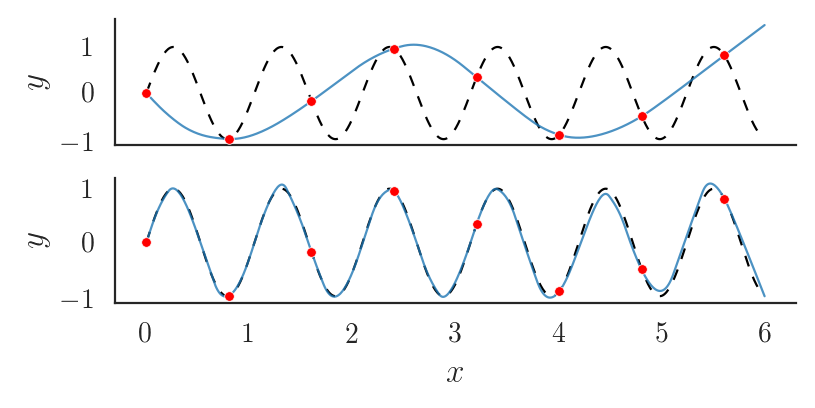

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(4, 2), dpi=200)

ax = axes[0]
sns.lineplot(x=x, y=y, lw=0.8, color='black', style=True, dashes=[(5, 5)], label='True', ax=ax, zorder=1)
sns.lineplot(x=x, y=y_pred_1, lw=0.8, alpha=0.8, label='Pred', ax=ax, zorder=2)
sns.scatterplot(x=x_train.numpy().ravel(), y=y_train.numpy().ravel(), color='red', s=12, ax=ax, zorder=3)
ax.legend([], frameon=False)
ax.set_xticks([])
ax.set_ylabel('$y$')

ax = axes[1]
sns.lineplot(x=x, y=y, lw=0.8, color='black', style=True, dashes=[(5, 5)], label='True', ax=ax, zorder=1)
sns.lineplot(x=x, y=y_pred_2, lw=0.8, alpha=0.8, label='Pred', ax=ax, zorder=2)
sns.scatterplot(x=x_train.numpy().ravel(), y=y_train.numpy().ravel(), color='red', s=12, ax=ax, zorder=3)
ax.legend([], frameon=False)
# ax.set_xticks([])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

sns.despine()
fig.savefig('figures/pde_sin.pdf', dpi=300, bbox_inches='tight')
fig.tight_layout()
plt.show()